In [4]:
import numpy as np
from scipy.special import sinc
import matplotlib.pyplot as plt
from functions import polyeig, Plasma, Spectral

In [49]:
N = 201
domain = "symmetric"
method = "FD"
spectral = Spectral(N,domain,method)

x = spectral.x
D1 = spectral.D1
D2 = spectral.D2
I = np.eye(*D1.shape)
O = np.zeros_like(I)

f = lambda x: 10*np.exp(-(10*x)**2)

## Finite-difference

$$ \left(\omega^2 - 2f(z)\omega + f(z)^2+\frac{d^2}{dz^2}\right)\xi(z) $$

Text(0, 0.5, '$\\Im(\\omega)$')

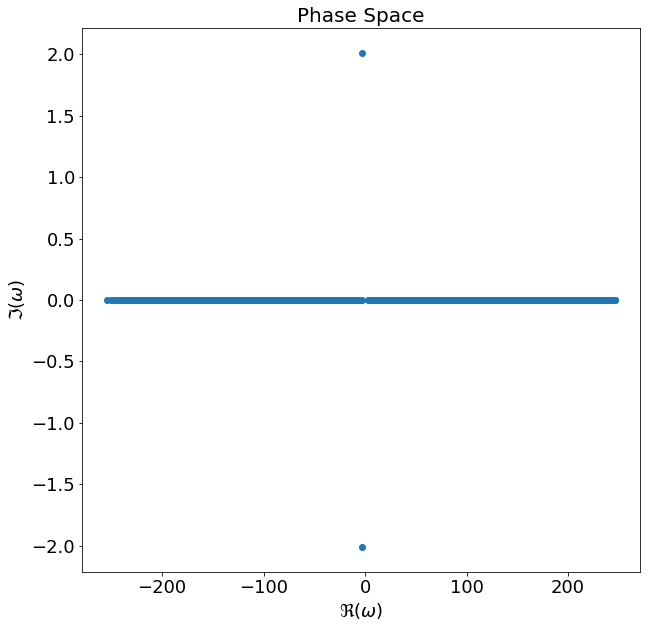

In [50]:
# finite-difference + polynomial eigenvalue problem
A2 = I
A1 = 2*f(x)*I
A0 = f(x)**2*I + D2

V,omega = polyeig(A0,A1,A2)

plt.figure()
plt.plot(np.real(omega), np.imag(omega), 'o')
plt.title("Phase Space")
plt.xlabel("$\Re(\omega)$")
plt.ylabel("$\Im(\omega)$")

## Finite-element
Let $\xi(z) = \frac{a_0}{2} + \sum_{n=1}^{N} a_n\cos(n\pi z)$, $\phi_n(z)=\cos(n\pi z)$. 
Then 

$$ H_{ij} = \langle\phi_i'|\phi_j'\rangle - \langle\phi_i|f^2|\phi_j\rangle = ij\pi^2\delta_{ij} - \int_{-1}^{1} \phi_i f^2 \phi_j $$
$$ f_{ij} = \langle\phi_i|f|\phi_j\rangle = \int_{-1}^{1} \phi_i f \phi_j  $$

In [82]:
from scipy.integrate import quad

N = 10

F = np.zeros((N,N))
H = np.zeros((N,N))
I = np.eye(N)
O = np.zeros_like(I)

f = lambda x: 10*np.exp(-(5*x)**2)
phi = lambda x,n: np.cos(n*np.pi*x/2) #np.cos(n*np.pi*x)
delta = lambda i,j: 1 if i==j else 0

# The basis function needs

for i in range(N):
    for j in range(N):
        F[i,j] = quad(lambda x: phi(x,i)*f(x)*phi(x,j), -1,1)[0]
        H[i,j] = quad(lambda x: i*j*(np.pi/2)**2*delta(i,j) - phi(x,i)*f(x)**2*phi(x,j), -1,1)[0]
V = np.pad(V, ((1,1),(0,0)), constant_values=0)

Text(0, 0.5, '$\\xi(z)$')

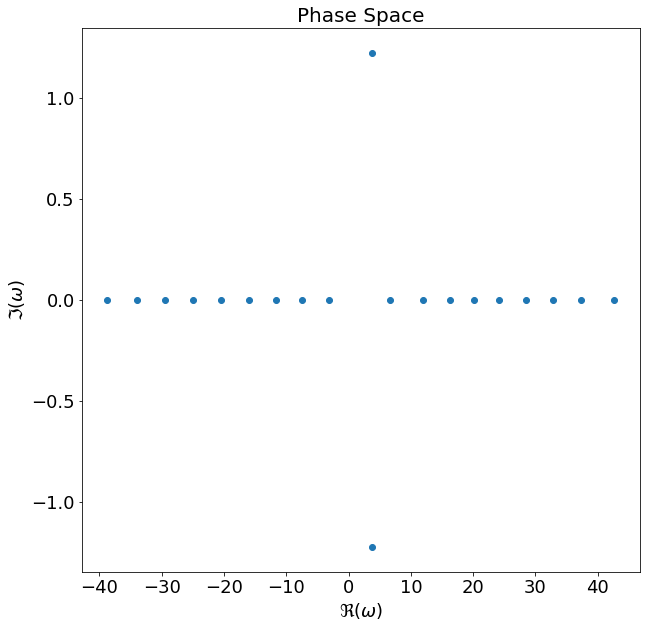

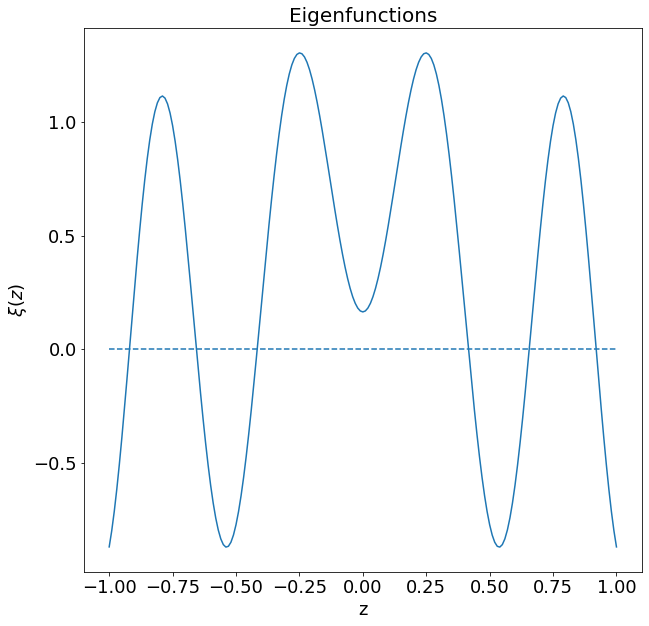

In [84]:
# finite-element + polynomial eigenvalue problem
A2 = -I
A1 = 2*F
A0 = H
V,e = polyeig(A0,A1,A2)

plt.figure()
plt.plot(np.real(omega), np.imag(omega), 'o')
plt.title("Phase Space")
plt.xlabel("$\Re(\omega)$")
plt.ylabel("$\Im(\omega)$")

plt.figure()
selection = e>0
c = V[:,selection]
phi_matrix = np.column_stack([phi(x,i) for i in range(N)])
xi = phi_matrix@c[:,2]
lines = plt.plot(x,np.real(xi),'-',label="$\Re(\\xi)$")
plt.plot(x,np.imag(xi),'--',color=lines[0]._color,label="$\Im(\\xi)$")
plt.title("Eigenfunctions")
plt.xlabel("z")
plt.ylabel("$\\xi(z)$")

Text(0, 0.5, '$\\Im(\\omega)$')

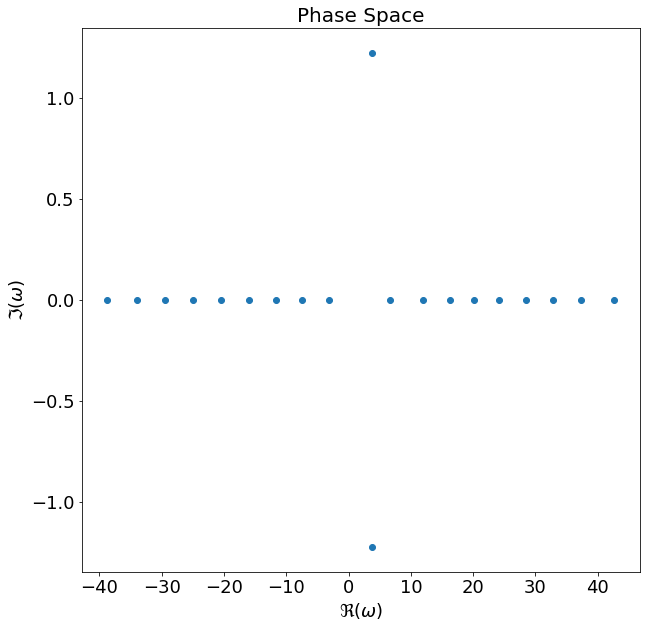

In [56]:
# finite-element + linear eigenvalue problem
A = np.block([[O,I],[H,2*F]])
omega,V = np.linalg.eig(A)
plt.figure()
plt.plot(np.real(omega), np.imag(omega), 'o')
plt.title("Phase Space")
plt.xlabel("$\Re(\omega)$")
plt.ylabel("$\Im(\omega)$")